# 5. Machine Learning Contd. - 2

## In Depth: k-Means Clustering

* The “cluster center” is the arithmetic mean of all the points belonging to the cluster.

* Each point is closer to its own cluster center than to other cluster centers.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  
import numpy as np

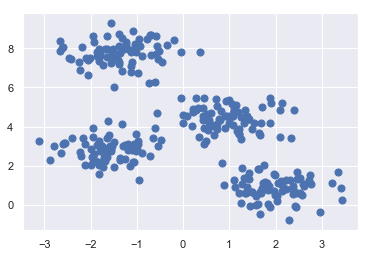

In [2]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                      cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

In [3]:
from sklearn.cluster import KMeans ######################

kmeans = KMeans(n_clusters=4)
kmeans.fit(X)

y_kmeans = kmeans.predict(X)

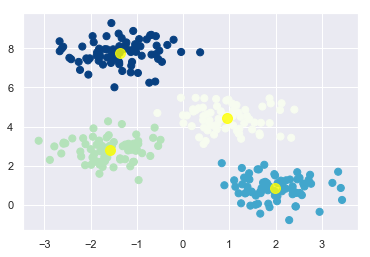

In [9]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap=plt.cm.GnBu)

centers = kmeans.cluster_centers_

plt.scatter(centers[:, 0], centers[:, 1], c='yellow', s=100, alpha=0.8);

In [10]:
centers

array([[ 0.94973532,  4.41906906],
       [-1.58438467,  2.83081263],
       [ 1.98258281,  0.86771314],
       [-1.37324398,  7.75368871]])

### k-Means Algorithm: Expectation–Maximization

![](kmeans.png)

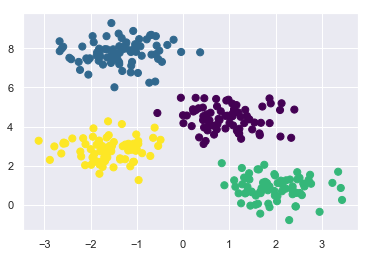

In [12]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]

    while True:
       # 2a. Assign labels based on closest center
       labels = pairwise_distances_argmin(X, centers)

       # 2b. Find new centers from means of points
       new_centers = np.array([X[labels == i].mean(0)
                               for i in range(n_clusters)])

       # 2c. Check for convergence
       if np.all(centers == new_centers):
            break
       centers = new_centers

    return centers, labels

centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis');

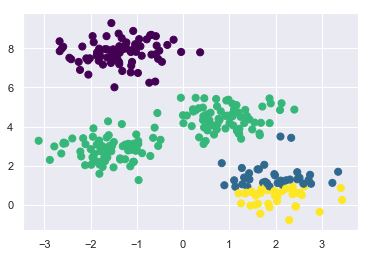

In [13]:
centers, labels = find_clusters(X, 4, rseed=0)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis');

Here the E–M approach has converged, but has not converged to a globally optimal configuration. For this reason, **it is common for the algorithm to be run for multiple starting guesses, as indeed Scikit-Learn does by default (set by the `n_init` parameter, which defaults to 10)**

**Another common challenge with k-means is that you must tell it how many clusters you expect: it cannot learn the number of clusters from the data.**

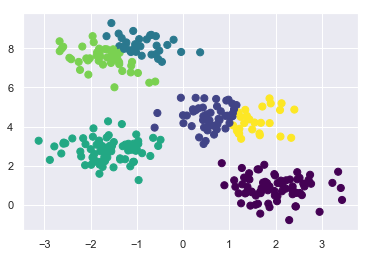

In [14]:
labels = KMeans(6, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis');


Alternatively, you might use a more complicated clustering algorithm which has a better quantitative measure of the fitness per number of clusters (e.g., `Gaussian` mixture models; or which can choose a suitable number of clusters (e.g., `DBSCAN`, `mean-shift`)

In particular, the boundaries between k-means clusters will always be linear, which means that it will fail for more complicated boundaries.

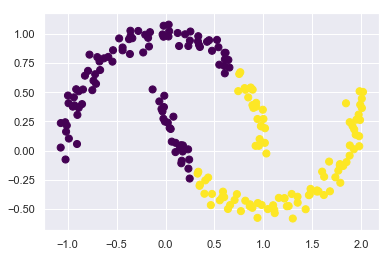

In [15]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)

labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis');

we used a kernel transformation in Support Vector Machines to project the data into a higher dimension where a linear separation is possible

One version of this kernelized k-means is implemented in Scikit-Learn within the `SpectralClustering` estimator.

/Users/hakan/.pyenv/versions/miniconda3-latest/lib/python3.5/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


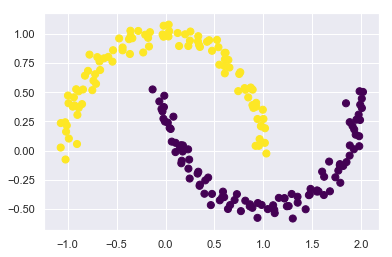

In [16]:
from sklearn.cluster import SpectralClustering ##################

model = SpectralClustering(n_clusters=2,
                           affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis');

We see that with this kernel transform approach, the kernelized k-means is able to find the more complicated nonlinear boundaries between clusters.

### EXAMPLE 1: K-MEANS ON DIGITS

In this example, we will attempt to use k-means to try to identify similar digits without using the original label information

In [17]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [18]:
kmeans = KMeans(n_clusters=10, random_state=0) ################
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

In [36]:
clusters

array([5, 7, 7, ..., 7, 3, 3], dtype=int32)

Notice that the cluster centers themselves are 64-dimensional points, and can themselves be interpreted as the “typical” digit within the cluster.

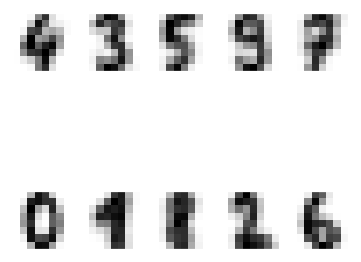

In [35]:
fig = plt.figure(figsize=(6, 6))

for i, image in enumerate(kmeans.cluster_centers_):
    
    ax = fig.add_subplot(2, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(image.reshape(8,8), cmap=plt.cm.binary, interpolation='nearest')

We see that even without the labels, KMeans is able to find clusters whose centers are recognizable digits

In [37]:
from scipy.stats import mode

labels = np.zeros_like(clusters)

for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

In [38]:
labels

array([0, 8, 8, ..., 8, 9, 9], dtype=int32)

In [39]:
from sklearn.metrics import accuracy_score

accuracy_score(digits.target, labels)

0.7935447968836951

With just a simple k-means algorithm, we discovered the correct grouping for 80% of the input digits!

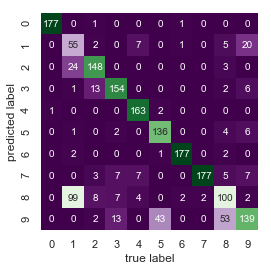

In [41]:
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(digits.target, labels)

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cmap=plt.cm.PRGn, cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

We can use the t-distributed stochastic neighbor embedding (t-SNE) algorithm to preprocess the data before performing k-means.

In [42]:
from sklearn.manifold import TSNE

# Project the data: this step will take several seconds
tsne = TSNE(n_components=2, init='pca', random_state=0)
digits_proj = tsne.fit_transform(digits.data)

# Compute the clusters
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj)

# Permute the labels
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

# Compute the accuracy
accuracy_score(digits.target, labels)

0.9398998330550918

In [43]:
digits_proj.shape

(1797, 2)

In [44]:
clusters.shape

(1797,)

That’s nearly 94% classification accuracy without using the labels.

In [46]:
digits.target[(clusters == 1)]

array([5, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 5, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 5, 9, 5, 9, 9, 5, 5, 9, 9, 5, 9, 9, 5, 9, 9, 5, 5, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 5, 9, 9, 9,
       9, 9, 9, 9, 9, 5, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9])

In [49]:
digits.target[(clusters == 1)].shape

(156,)

In [47]:
mode(digits.target[(clusters == 1)]) 
# 12 5, 144 9

ModeResult(mode=array([9]), count=array([144]))

### EXAMPLE 2: K-MEANS FOR COLOR COMPRESSION

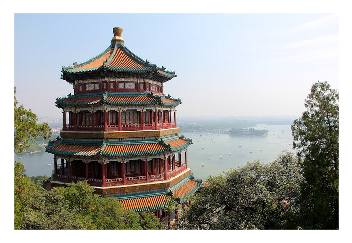

In [50]:
# Note: this requires the pillow package to be installed
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")

ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china);

In [51]:
china.shape

(427, 640, 3)

In [52]:
data = china / 255.0 # use 0...1 scale
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

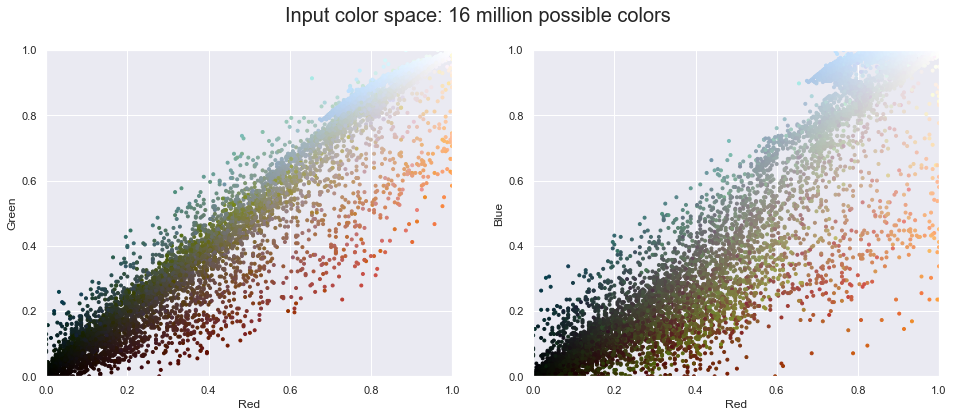

In [54]:
 def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data

    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T

    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

plot_pixels(data, title='Input color space: 16 million possible colors')

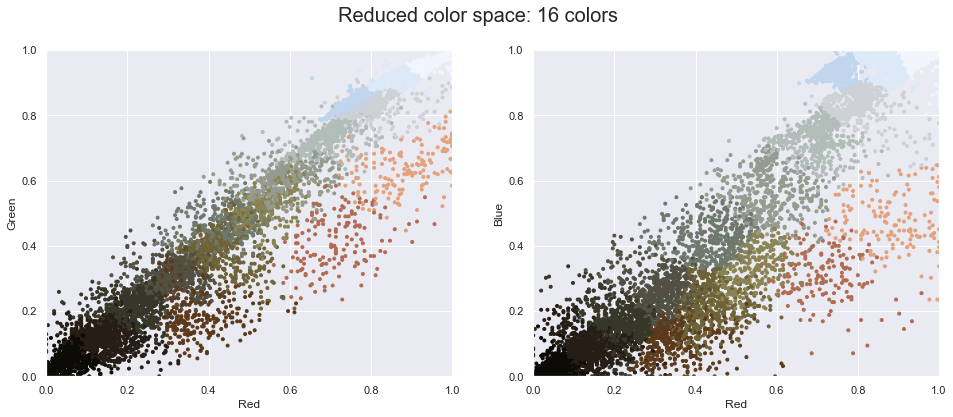

In [55]:
from sklearn.cluster import MiniBatchKMeans #################

kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors,
            title="Reduced color space: 16 colors")

In [56]:
new_colors.shape

(273280, 3)

In [58]:
kmeans.predict(data)

array([9, 9, 9, ..., 6, 0, 0], dtype=int32)

In [61]:
kmeans.predict(data).shape

(273280,)

In [57]:
kmeans.cluster_centers_

array([[0.04932249, 0.04393432, 0.02534672],
       [0.80850361, 0.82002064, 0.83401445],
       [0.31724337, 0.31430219, 0.26078431],
       [0.86211571, 0.91203099, 0.96729605],
       [0.58912656, 0.60778372, 0.56648841],
       [0.35686275, 0.22908497, 0.10580065],
       [0.21728691, 0.21584634, 0.15902361],
       [0.69389978, 0.4211329 , 0.31786492],
       [0.69632635, 0.73739013, 0.72481406],
       [0.75231373, 0.83780392, 0.93483922],
       [0.54100597, 0.51526002, 0.31960784],
       [0.89184727, 0.63137255, 0.4873065 ],
       [0.94623222, 0.96201461, 0.98802384],
       [0.43063725, 0.38588235, 0.21568627],
       [0.15002801, 0.11749767, 0.08459384],
       [0.43123249, 0.47072829, 0.42191877]])

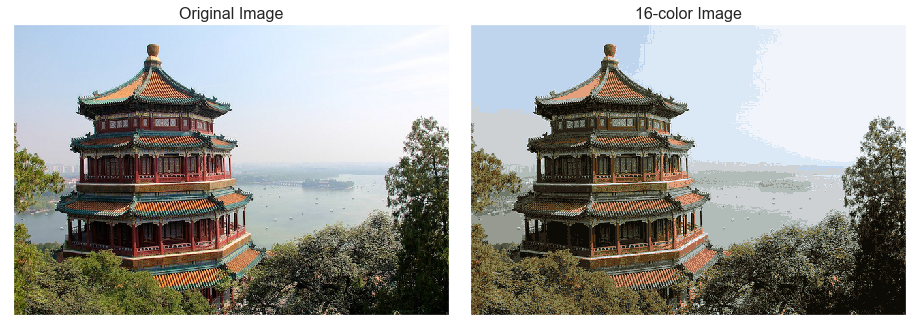

In [59]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6), subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)

ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16);

In [60]:
china_recolored.shape

(427, 640, 3)

## In Depth: Gaussian Mixture Models

In particular, the nonprobabilistic nature of k-means and its use of simple distance-from-cluster-center to assign cluster membership leads to poor performance for many real-world situations

Gaussian mixture models, which can be viewed as an extension of the ideas behind k-means, but can also be a powerful tool for estimation beyond simple clustering

### Motivating GMM: Weaknesses of k-Means

In [64]:
# Generate some data
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                      cluster_std=0.60, random_state=0)

print(X.shape)

X = X[:, ::-1] # flip axes for better plotting

(400, 2)


In [63]:
X.shape

(400, 2)

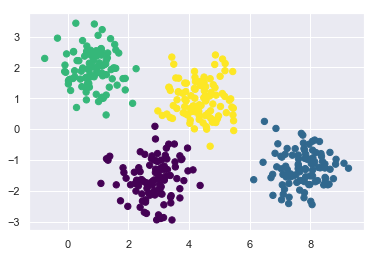

In [65]:
# Plot the data with k-means labels
from sklearn.cluster import KMeans

kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)

plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

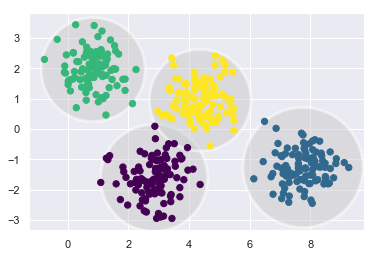

In [67]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the k-means model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

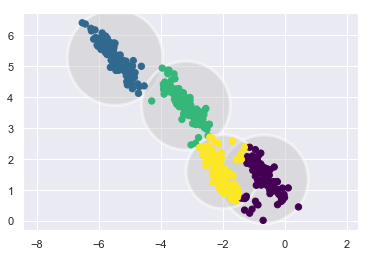

In [68]:
rng = np.random.RandomState(13)

X_stretched = np.dot(X, rng.randn(2, 2)) #######################

kmeans = KMeans(n_clusters=4, random_state=0)   #######################
plot_kmeans(kmeans, X_stretched)

These **two disadvantages of k-means**—its lack of flexibility in cluster shape and lack of probabilistic cluster assignment—mean that for many datasets (especially low-dimensional datasets) it may not perform as well as you might hope.

### Generalizing E–M: Gaussian Mixture Models

A Gaussian mixture model (GMM) attempts to find a mixture of multidimensional Gaussian probability distributions that best model any input dataset.

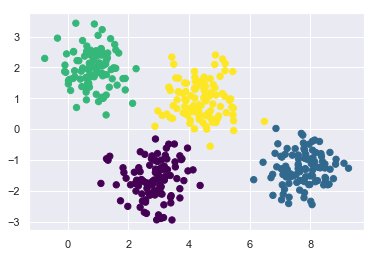

In [70]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');
# GMMs can be used for finding clusters in the same manner as k-means

`predict_proba method` returns a matrix of size `[n_samples, n_clusters]` that measures the probability that any point belongs to the given cluster:

In [72]:
labels[:5]

array([3, 0, 0, 3, 0])

In [71]:
probs = gmm.predict_proba(X)  #######################
print(probs[:5].round(3))

[[0.    0.469 0.    0.531]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [0.    0.    0.    1.   ]
 [1.    0.    0.    0.   ]]


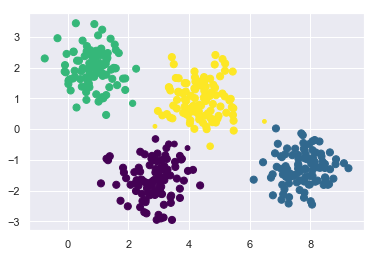

In [73]:
size = 50 * probs.max(1) ** 2  # square emphasizes differences
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);

In [77]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()

    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    # Draw the ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))

def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')

    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

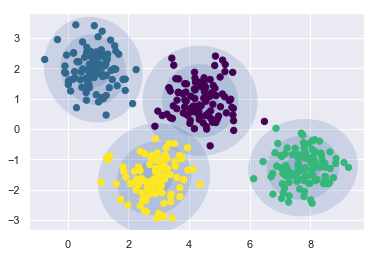

In [78]:
gmm = GaussianMixture(n_components=4, random_state=42)
plot_gmm(gmm, X)

Similarly, we can use the `GaussianMixture` approach to fit our stretched dataset; allowing for a full covariance, the model will fit even very oblong, stretched-out clusters:

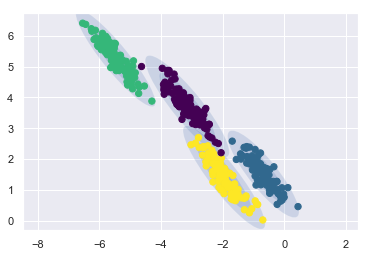

In [79]:
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42) #######################
plot_gmm(gmm, X_stretched)

**This makes clear that GaussianMixture address the two main practical issues with k-means encountered before.**

### CHOOSING THE COVARIANCE TYPE